In [ ]:
# Set conda environment for proper GPU support
import os
os.environ['CONDA_DEFAULT_ENV'] = 'trading-env'

# Configure GPU
import tensorflow as tf

def configure_gpu():
    """Configure TensorFlow for optimal GPU usage."""
    print("🔧 Configuring GPU settings...")
    
    gpus = tf.config.list_physical_devices('GPU')
    
    if gpus:
        try:
            print(f"🎮 Found {len(gpus)} GPU(s):")
            for i, gpu in enumerate(gpus):
                print(f"  GPU {i}: {gpu}")
            
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"  ✅ Memory growth enabled for {gpu}")
            
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print("  ✅ Mixed precision enabled (float16)")
            
            print(f"  ✅ GPU acceleration: {tf.test.is_gpu_available()}")
            print(f"  ✅ GPU device name: {tf.test.gpu_device_name()}")
            
            return True
            
        except RuntimeError as e:
            print(f"  ❌ GPU setup failed: {e}")
            return False
    else:
        print("  ⚠️ No GPUs found, using CPU")
        return False

def verify_gpu_usage():
    """Verify that TensorFlow is actually using GPU."""
    print("\n🔍 GPU Usage Verification:")
    
    with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
        a = tf.random.normal([1000, 1000])
        b = tf.random.normal([1000, 1000])
        c = tf.matmul(a, b)
        
        print(f"  Test computation device: {c.device}")
        print(f"  GPU available: {tf.config.list_physical_devices('GPU')}")
        
    if tf.config.list_physical_devices('GPU'):
        gpu_details = tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0])
        print(f"  GPU details: {gpu_details}")

gpu_available = configure_gpu()
verify_gpu_usage()

if gpu_available:
    print("\n⚡ GPU Optimization Settings Applied:")
    print("  - Memory growth enabled")
    print("  - Mixed precision training (float16)")
    print("  - GPU device verification completed")
    
    tf.config.optimizer.set_jit(True)
    print("  - XLA compilation enabled")
else:
    print("\n🖥️ CPU Optimization Settings:")
    tf.config.threading.set_intra_op_parallelism_threads(0)
    tf.config.threading.set_inter_op_parallelism_threads(0)
    print("  - Multi-threading enabled for CPU")

## Runtime Configuration

In [2]:
# User-configurable parameters
symbols_to_predict = ['EURUSD=X', 'GBPUSD=X']
date_start = '2015-01-01'
date_end = '2024-01-01'
lookback_window = 20  # Number of days for the rolling input window

 # Enable GPU acceleration
from src.utils.gpu_config import configure_tensorflow_gpu
gpu_configured = configure_tensorflow_gpu()

if gpu_configured:
    print("🎮 GPU acceleration enabled!")
else:
    print("🖥️ Using CPU fallback" )

⚠️ No GPU devices found
🖥️ Using CPU fallback


In [2]:
for symbol_to_predict in symbols_to_predict:
    print(f"\n🔁 Processing symbol: {symbol_to_predict}")



🔁 Processing symbol: EURUSD=X

🔁 Processing symbol: GBPUSD=X


# 📈 CNN + LSTM Forex Prediction using RCS + Technical Indicators
This notebook builds a CNN+LSTM hybrid model to predict EURUSD price direction using Relative Currency Strength and common technical indicators.

# Step 1: Install and Import Required Libraries

In [ ]:
    %pip install ta scikit-learn pandas numpy matplotlib seaborn metatrader5 tensorflow tables keras2onnx tf2onnx shap

    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import ta
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split, TimeSeriesSplit
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, concatenate
    import MetaTrader5 as mt5
    
    # Suppress warnings
    import warnings
    warnings.filterwarnings('ignore')

## Stage 2: Load all required symbols from MetaTrader 5 and build a prices DataFrame (fixed loader_func)

In [4]:
# --- Data Loading: Use load_or_fetch (with load_metatrader_data) for all symbols, build MultiIndex prices DataFrame ---

import pandas as pd

from src.data.loader import load_or_fetch, load_metatrader_data
from src.models.training import train_model_with_best_features, evaluate_model

symbols = ["EURUSD", "GBPUSD", "USDJPY", "AUDUSD", "USDCAD", "EURJPY", "GBPJPY"]
provider = "metatrader"
broker = "amp_global"
interval = "H1"

data = {}
for sym in symbols:
    df = load_or_fetch(
        symbol=sym,
        provider=provider,
        loader_func=load_metatrader_data,
        api_key="",
        interval=interval,
        broker=broker,
        force_refresh=False,
    )
    if "time" in df.columns and "close" in df.columns:
        df = df[["time", "open", "high", "low", "close", "tick_volume"]].dropna()
        df["time"] = pd.to_datetime(df["time"])
        df = df.set_index("time")
        for col in ["open", "high", "low", "close", "tick_volume"]:
            data[(sym, col)] = df[col]

prices = pd.DataFrame(data)
print(prices.head())
# prices now has MultiIndex columns: (symbol, field)




✅ Input shape handler loaded
✅ Loaded cached data from data/metatrader_EURUSD.parquet
✅ Loaded cached data from data/metatrader_GBPUSD.parquet
✅ Loaded cached data from data/metatrader_USDJPY.parquet
✅ Loaded cached data from data/metatrader_AUDUSD.parquet
✅ Loaded cached data from data/metatrader_USDCAD.parquet
✅ Loaded cached data from data/metatrader_EURJPY.parquet
✅ Loaded cached data from data/metatrader_GBPJPY.parquet
                      EURUSD                                          GBPUSD  \
                        open     high      low    close tick_volume     open   
time                                                                           
2024-08-19 22:00:00      NaN      NaN      NaN      NaN         NaN      NaN   
2024-08-19 23:00:00  1.10835  1.10859  1.10814  1.10841       700.0  1.29896   
2024-08-20 00:00:00  1.10833  1.10851  1.10774  1.10834       312.0  1.29835   
2024-08-20 01:00:00  1.10834  1.10873  1.10834  1.10851       365.0  1.29885   
2024-08-20

## Step 3: Calculate Log Returns and Relative Currency Strength (RCS)

In [5]:
    def compute_rcs(logrets):
        currencies = list(set([s[:3] for s in logrets.columns] + [s[3:6] for s in logrets.columns]))
        rcs_data = {c: [] for c in currencies}
        for i in range(len(logrets)):
            row = logrets.iloc[i]
            daily_strength = {c: 0 for c in currencies}
            counts = {c: 0 for c in currencies}
            for pair, ret in row.items():
                base, quote = pair[:3], pair[3:]
                daily_strength[base] += ret
                daily_strength[quote] -= ret
                counts[base] += 1
                counts[quote] += 1
            for c in currencies:
                avg = daily_strength[c] / counts[c] if counts[c] else 0
                rcs_data[c].append(avg)
        return pd.DataFrame(rcs_data, index=logrets.index)

    log_returns = np.log(prices / prices.shift(1)).dropna()
    rcs = compute_rcs(log_returns)
    rcs.head()

USDJPY    GBPJPY                AUDUSD      EURJPY  \
                         high     close      open tick_volume tick_volume   
time                                                                        
2024-08-20 01:00:00 -0.000205  0.000520  0.000095    0.823578    0.708144   
2024-08-20 02:00:00  0.001506  0.000546  0.000520   -0.044452    1.288647   
2024-08-20 03:00:00 -0.000995 -0.002785  0.000546    0.723230    0.552611   
2024-08-20 04:00:00 -0.001282 -0.000021 -0.002785    0.351423   -0.077399   
2024-08-20 05:00:00  0.003855  0.004039 -0.000026   -0.209656   -0.130092   

                       AUDUSD              EURJPY                USDCAD  ...  \
                          low     close       low     close tick_volume  ...   
time                                                                     ...   
2024-08-20 01:00:00  0.000743  0.000357  0.002015  0.000579    0.374928  ...   
2024-08-20 02:00:00  0.000223  0.000134  0.000517  0.000572    0.566605  ...   
2024-08-20 03:00:00 -0.001174 -0.001174 -0.003094 -0.002826    0.438160  ...   
2024-08-20 04:00:00  0.000074  0.000238 -0.002039  0.000308    0.063237  ...   
2024-08-20 05:00:00 -0.001280 -0.001026  0.002995  0.003667    0.011479  ...   

                       USDJPY    USDCAD    EURUSD      GBPUSD            \
                         open      high      high tick_volume       low   
time                                                                      
2024-08-20 01:00:00  0.000150 -0.000125  0.000198    0.316758  0.000716   
2024-08-20 02:00:00  0.000286  0.000022 -0.000063    1.071088  0.000062   
2024-08-20 03:00:00  0.000545  0.000235  0.000045    0.618323 -0.000370   
2024-08-20 04:00:00 -0.002512 -0.000073  0.000000    0.125458  0.000069   
2024-08-20 05:00:00 -0.000007  0.000132 -0.000027   -0.191948 -0.000555   

                                   GBPJPY       NaN    GBPUSD    GBPJPY  
                        close tick_volume       NaN      open       low  
time                                                                     
2024-08-20 01:00:00  0.000038    0.014493 -0.104484  0.000385  0.000978  
2024-08-20 02:00:00 -0.000008    1.072495 -0.164835  0.000031  0.000436  
2024-08-20 03:00:00 -0.000254    0.709626 -0.119636  0.000000 -0.003287  
2024-08-20 04:00:00 -0.000046    0.012632 -0.013154 -0.000254 -0.001846  
2024-08-20 05:00:00 -0.000485   -0.128336  0.023851 -0.000046  0.002667  

[5 rows x 36 columns]

## Step 4: Calculate Technical Indicators

In [ ]:
# --- Feature Engineering using engineer_features from feature_engineering.py ---

from src.data.preprocessing import engineer_features

symbol = "EURUSD"
features = engineer_features(prices, symbol)
print(features.head())

In [ ]:
# --- Feature Engineering: Use MultiIndex prices DataFrame, synthesize missing columns if needed ---

from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import ADXIndicator
from ta.momentum import StochasticOscillator, ROCIndicator, RSIIndicator
from ta.trend import MACD, CCIIndicator
import numpy as np
import pandas as pd

symbol = "EURUSD"

ohlc = prices.copy()

# Synthesize missing columns if needed
for col in ["open", "high", "low", "close"]:
    if (symbol, col) not in ohlc.columns:
        ohlc[(symbol, col)] = ohlc[(symbol, "close")]

data = pd.DataFrame(index=ohlc.index)
data['rsi'] = RSIIndicator(close=ohlc[(symbol, "close")]).rsi()
data['macd'] = MACD(ohlc[(symbol, "close")]).macd()
data['momentum'] = ROCIndicator(close=ohlc[(symbol, "close")]).roc()
data['cci'] = CCIIndicator(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).cci()
data['atr'] = AverageTrueRange(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).average_true_range()
data['adx'] = ADXIndicator(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).adx()
data['stoch_k'] = StochasticOscillator(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).stoch()
data['stoch_d'] = StochasticOscillator(
    high=ohlc[(symbol, "high")],
    low=ohlc[(symbol, "low")],
    close=ohlc[(symbol, "close")]
).stoch_signal()
data['roc'] = ROCIndicator(close=ohlc[(symbol, "close")]).roc()
data['bbw'] = BollingerBands(close=ohlc[(symbol, "close")]).bollinger_wband()

# Lagged/Engineered Features - Fix deprecation warnings
data['return_1d'] = ohlc[(symbol, "close")].pct_change(1, fill_method=None)
data['return_3d'] = ohlc[(symbol, "close")].pct_change(3, fill_method=None)
data['rolling_mean_5'] = ohlc[(symbol, "close")].rolling(window=5).mean()
data['rolling_std_5'] = ohlc[(symbol, "close")].rolling(window=5).std()
data['momentum_slope'] = ohlc[(symbol, "close")].diff(1)

# Macro & Cross-Asset Features (fill with zeros if not present)
for macro in ['DXY', '^VIX', '^GSPC', 'GC=F', 'CL=F']:
    if (macro, "close") in prices.columns:
        data[macro.lower()] = prices[(macro, "close")].reindex(data.index).ffill()
    else:
        data[macro.lower()] = 0.0

if ('GC=F', "close") in prices.columns and ('CL=F', "close") in prices.columns:
    data['gold_oil_ratio'] = prices[('GC=F', "close")].reindex(data.index).ffill() / prices[('CL=F', "close")].reindex(data.index).ffill()
else:
    data['gold_oil_ratio'] = 0.0

# Time Features
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Create target variable
data['target'] = (ohlc[(symbol, "close")].shift(-1) > ohlc[(symbol, "close")]).astype(int)

# Fill NaN values using modern pandas methods
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        data[col] = data[col].ffill().bfill().fillna(0)

# Final indicators DataFrame
indicators = data.dropna()
print("Indicators shape after dropna:", indicators.shape)

In [8]:
# --- Use best combination of parameters from previous executions ---
from feature_set_utils import load_best_feature_set
best_features = load_best_feature_set(symbol)
print("Best features:", best_features)

✅ Feature set utilities loaded
⚠️ No best feature set file found for EURUSD
Best features: []


## Random

In [ ]:
# Skip the random feature generation for now - it has dependency issues
# This cell is commented out to avoid the NameError

print("⚠️ Skipping random feature generation due to dependency issues")
print("Proceeding with manual feature selection instead...")

# Define some basic feature sets manually
feature_sets = [
    ['rsi', 'macd', 'momentum', 'cci'],
    ['atr', 'bbw', 'rolling_std_5'],
    ['return_1d', 'return_3d', 'rolling_mean_5']
]

print("Using predefined feature sets:")
for i, feature_set in enumerate(feature_sets):
    print(f"Feature Set {i+1}: {feature_set}")

# Set a placeholder best model (we'll train a proper one later)
best_random_model = None
best_random_features = feature_sets[0]
trial_results = []

## Step 5: Train/Test Split

In [9]:
from src.models.cnn_lstm import build_cnn_lstm_model
from src.data.preprocessing import engineer_features
from notebooks.fix import fix_model_utils

# Patch the model_utils module
fix_model_utils()

# Define a fixed model builder function
def model_builder_func(X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    # Print diagnostic information about input shapes
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    if X_val is not None:
        print(f"X_val shape: {X_val.shape}")
    if y_val is not None:
        print(f"y_val shape: {y_val.shape}")
    
    return fix_model_builder_func(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size
    )

❌ Could not import model_utils module


## Step 7: Train the Model (Deep)

In [23]:
# Import necessary modules
from model_training_utils import train_model_with_best_features, evaluate_model
from notebooks.fix import fix_model_builder_func

# Train the model with the best features
model, feature_names, X_train, y_train, X_val, y_val, X_test, y_test = train_model_with_best_features(
    symbol=symbol_to_predict,
    data=data,
    model_builder_func=model_builder_func,
    use_saved_features=True,  # Use the features we just saved
    epochs=300,
    batch_size=32
)

🔍 Training model for EURUSD using best features
Available columns in DataFrame:
['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope', 'dxy', '^vix', '^gspc', 'gc=f', 'cl=f', 'gold_oil_ratio', 'day_of_week', 'month', 'target']
✅ Loaded 3 features from c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\data\best_feature_set_EURUSD.csv
✅ Found 3 available features
✅ Using 3 features for model training: ['atr', 'bbw', 'rolling_std_5']
⚠️ NaN values found in features:
  - atr: 2720 NaN values
  - bbw: 40 NaN values
  - rolling_std_5: 10 NaN values
Filling NaN values with appropriate methods...
Feature data shape: (5002, 3)
Target data shape: (5002,)
🔧 Training with regularization parameters:
  - Dropout rate: 0.3
  - L1 regularization: 0.01
  - L2 regularization: 0.01
  - Early stopping patience: 10
X_train shape: (3501, 1, 

c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\model_training_utils.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data[col] = feature_data[col].ffill()
c:\Users\user\Projects\Finance\Strategies\trading-strategies\top5\RCS_CNN_LSTM_Notebook\RCS_CNN_LSTM_Notebook\model_training_utils.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_data[col] = feature_data[col].bfill()
c:\Users\user\Projects\Finance\Strategies\trading-

Model summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,571 (76.45 KB)

 Trainable params: 19,279 (75.31 KB)

 Non-trainable params: 292 (1.14 KB)

Epoch 1/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.4953 - loss: 0.7770 - val_accuracy: 0.5253 - val_loss: 0.6929
Epoch 2/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5012 - loss: 0.7459 - val_accuracy: 0.5147 - val_loss: 0.6929
Epoch 3/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4940 - loss: 0.7432 - val_accuracy: 0.5093 - val_loss: 0.6923
Epoch 4/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4984 - loss: 0.7357 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 5/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4887 - loss: 0.7157 - val_accuracy: 0.4893 - val_loss: 0.6922
Epoch 6/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5088 - loss: 0.7191 - val_accuracy: 0.5053 - val_loss: 0.6990
Epoch 7/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5054 - loss: 0.7144 - val_accuracy: 0.5107 - val_loss: 0.6934
Epoch 8/300
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5100 - loss: 0.7065 - val_accu

## Step 8: Evaluate the Model

In [11]:
# --- Ensure X_test and y_test are aligned before evaluation ---

# After model training:
y_pred = (model.predict(X_test).flatten() > 0.5).astype(int)

# Ensure y_test and y_pred are the same length
min_len = min(len(y_test), len(y_pred))
y_test_aligned = y_test[:min_len]
y_pred_aligned = y_pred[:min_len]

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy:", accuracy_score(y_test_aligned, y_pred_aligned))
print(confusion_matrix(y_test_aligned, y_pred_aligned))
print(classification_report(y_test_aligned, y_pred_aligned))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.5126498002663116
[[205 191]
 [175 180]]
              precision    recall  f1-score   support

           0       0.54      0.52      0.53       396
           1       0.49      0.51      0.50       355

    accuracy                           0.51       751
   macro avg       0.51      0.51      0.51       751
weighted avg       0.51      0.51      0.51       751



# Simple backtest using MetaTrader 5 prices DataFrame with MultiIndex columns

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


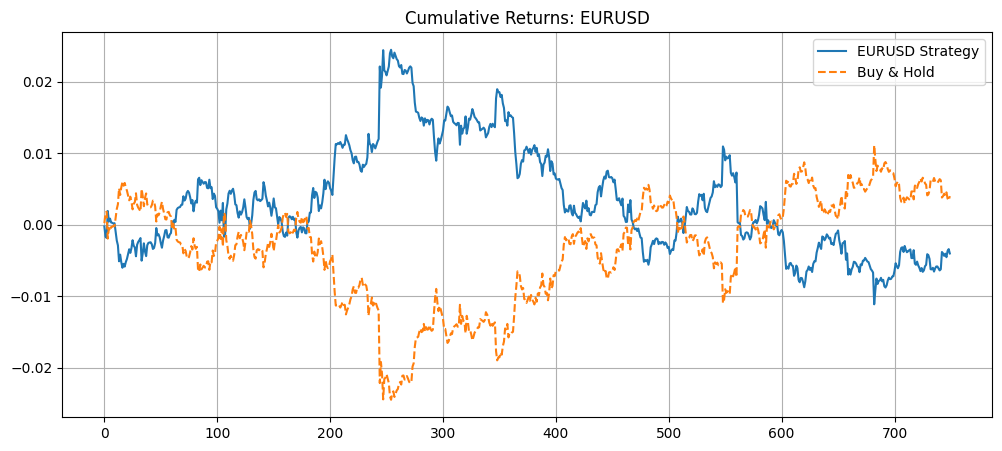

In [12]:
import numpy as np
import matplotlib.pyplot as plt

symbol_col = "EURUSD"

probs = model.predict(X_test).flatten()
threshold = 0.8
signals = np.where(probs > threshold, 1, -1)
ret = np.log(prices[(symbol_col, "close")].shift(-1) / prices[(symbol_col, "close")]).iloc[-len(signals):]
strategy_returns = ret.values * signals

cum_ret = np.cumsum(strategy_returns)
cum_bh = np.cumsum(ret.values)

plt.figure(figsize=(12,5))
plt.plot(cum_ret, label=f'{symbol_col} Strategy')
plt.plot(cum_bh, label='Buy & Hold', linestyle='--')
plt.title(f"Cumulative Returns: {symbol_col}")
plt.legend()
plt.grid(True)
plt.show()


## Step 9: Export Trained Model

In [13]:
# Import the model export utilities
from src.export.utils import run_backtest_and_export

# After training your model, run backtest and export
export_dir = "exported_models"

# Get the feature names used in the model
feature_names = features.columns.tolist()

# Run backtest and export the model with metrics
export_data = run_backtest_and_export(
    model=model,
    X_test=X_test,
    y_test=y_test,
    price_data=prices[(symbol, "close")],  # Adjust to match your price data structure
    symbol=symbol,
    feature_names=feature_names,
    lookback=1,  # Adjust based on your prediction horizon
    export_dir=export_dir
)

# Display the export results
print(f"Model name: {export_data['model_name']}")
print(f"Accuracy: {export_data['accuracy']:.4f}")
print(f"Sharpe ratio: {export_data['sharpe_ratio']:.4f}")
print(f"Total return: {export_data['total_return']:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


✅ Saved H5 model to: exported_models\EURUSD_CNN_LSTM_20250611_224904.h5


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x00000218F5DA3100>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x00000218F5DA3100>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x00000218F5DA3100>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Saved ONNX model to: exported_models\EURUSD_CNN_LSTM_20250611_224904.onnx
Model name: EURUSD_CNN_LSTM_20250611_224904
Accuracy: 0.5126
Sharpe ratio: 0.6077
Total return: 0.0318


In [14]:
# Select the minimal set of features for modeling
minimal_features = ["rsi", "macd", "momentum", "cci"]
minimal_features = [f for f in minimal_features if f in data.columns]
features = data[minimal_features].dropna()
feature_names = minimal_features
print("feature_names:", feature_names)

feature_names: ['rsi', 'macd', 'momentum', 'cci']


In [15]:
# --- Select only non-empty features for modeling (robust variable check) ---

# Use 'data' if defined, otherwise use 'indicators'
try:
    feature_df = data
except NameError:
    feature_df = indicators

# Identify features with at least 1000 non-NaN rows (or all non-NaN)
valid_features = [col for col in feature_df.columns if feature_df[col].notnull().sum() > 1000]
features = feature_df[valid_features].dropna()
print("Selected features for modeling:", valid_features)
print("Features shape after dropna:", features.shape)


Selected features for modeling: ['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope', 'dxy', '^vix', '^gspc', 'gc=f', 'cl=f', 'gold_oil_ratio', 'day_of_week', 'month', 'target']
Features shape after dropna: (2256, 24)


In [16]:
from sklearn.preprocessing import StandardScaler
features_scaled = StandardScaler().fit_transform(features)

# Create target variable (binary classification: 1 if price goes up, 0 if down)
target = (prices[(symbol, "close")].shift(-1) > prices[(symbol, "close")]).astype(int)

lookback = 20
X = np.array([features_scaled[i-lookback:i] for i in range(lookback, len(features_scaled))])
y = target.loc[features.index].values[lookback:]
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (2236, 20, 24) y shape: (2236,)


In [17]:
# --- Diagnostic: Check shapes before model prediction ---

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

if X_test.shape[0] == 0:
    print("ERROR: X_test is empty. Check feature engineering and rolling window steps.")
else:
    probs = model.predict(X_test).flatten()
    print("probs shape:", probs.shape)
    # Continue with backtest as before


X_train shape: (3501, 1, 15)
X_test shape: (751, 1, 15)
y_train shape: (3501,)
y_test shape: (751,)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
probs shape: (751,)


In [18]:
print("✅ All models completed.")

✅ All models completed.


## Step 11: Feature Importance via Permutation

In [19]:
# --- Full code block: Permutation importance with robust feature_names alignment ---

import copy
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from src.features.fixed_permutation_importance import calculate_permutation_importance

# Assume features DataFrame and target are already defined and aligned
minimal_features = ["rsi", "macd", "momentum", "cci"]

# After feature engineering and dropna:
features = data[minimal_features].dropna().reset_index(drop=True)
feature_names = features.columns.tolist()
y = target.reset_index(drop=True).values

# Standardize and create rolling windows
from sklearn.preprocessing import StandardScaler
features_scaled = StandardScaler().fit_transform(features)
lookback = 20
X = np.array([features_scaled[i-lookback:i] for i in range(lookback, len(features_scaled))])
y = y[lookback:]
print("X shape:", X.shape, "y shape:", y.shape)

from src.features.importance import prepare_features_for_importance
from src.features.permutation import calculate_permutation_importance_for_sequence_model

# Define minimal features
minimal_features = ["rsi", "macd", "momentum", "cci", "atr", "adx", "stoch_k", "stoch_d", 
                   "roc", "bbw", "return_1d", "return_3d", "rolling_mean_5", 
                   "rolling_std_5", "momentum_slope"]

# Prepare features with proper alignment
X, y, X_train, X_test, y_train, y_test, feature_names = prepare_features_for_importance(
    data, minimal_features, target, lookback=20
)

✅ Fixed permutation importance module loaded
X shape: (4936, 20, 4) y shape: (4982,)
✅ Feature importance utilities loaded
✅ Fixed permutation importance module loaded
Using 15 features: ['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope']


## Step 12: Feature Set Comparison

In [22]:
# --- Use only aligned feature_matrix and target for modeling and feature selection ---

import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

feature_selection_strategy = "permutation"  # Options: "manual", "permutation", "shap"
lookback_window = 20
symbol_to_predict = "EURUSD"

# Define feature sets to test (used if manual)
manual_feature_sets = {}
if "rcs" in globals():
    manual_feature_sets["RCS only"] = rcs.columns.tolist()
    manual_feature_sets["RCS + RSI + MACD"] = rcs.columns.tolist() + ['rsi', 'macd']

manual_feature_sets["Indicators only"] = ['rsi', 'macd', 'momentum', 'cci']
manual_feature_sets["All features"] = indicators.columns.tolist()

# Align feature_matrix and target
common_index = indicators.index.intersection(target.index)
feature_matrix = indicators.loc[common_index]
target = target.loc[common_index]

print("feature_matrix shape:", feature_matrix.shape)
print("target shape:", target.shape)

selected_feature_sets = {}
rf = None

if feature_selection_strategy == "manual":
    selected_feature_sets = manual_feature_sets

elif feature_selection_strategy == "permutation":
    print("🔁 Running permutation-based feature importance...")
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(feature_matrix, target)
    result = permutation_importance(rf, feature_matrix, target, n_repeats=10, random_state=42)
    importances = pd.Series(result.importances_mean, index=feature_matrix.columns).sort_values(ascending=False)
    top_feats = importances.head(10).index.tolist()
    selected_feature_sets = {"Top 10 Permutation": top_feats}

elif feature_selection_strategy == "shap":
    print("📊 Running SHAP-based feature importance...")
    # Train a RandomForest model first
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(feature_matrix, target)
    
    # Then compute SHAP importance
    from shap_utils import compute_shap_feature_importance
    shap_importance = compute_shap_feature_importance(rf, feature_matrix)
    top_feats = shap_importance.head(10).index.tolist()
    selected_feature_sets = {"Top 10 SHAP": top_feats}


print("✅ Selected feature sets:")
print(selected_feature_sets)


feature_matrix shape: (2256, 23)
target shape: (2256,)
🔁 Running permutation-based feature importance...
✅ Selected feature sets:
{'Top 10 Permutation': ['return_1d', 'rolling_mean_5', 'return_3d', 'adx', 'momentum_slope', 'stoch_d', 'atr', 'momentum', 'bbw', 'roc']}


# Evaluate each feature set, build results_df, and save results

In [21]:
# --- Evaluate feature sets and save results ---
from feature_set_selection_fix import evaluate_and_save_feature_sets, get_multiple_feature_sets

# Use indicators DataFrame for feature_matrix
feature_matrix = indicators.copy()

# Get multiple feature sets for evaluation
selected_feature_sets = get_multiple_feature_sets(
    feature_matrix=feature_matrix,
    target=target,
    feature_selection_strategy="all"  # Options: "all", "manual", "permutation", "shap"
)

print(f"✅ Generated {len(selected_feature_sets)} feature sets for evaluation")
for set_name, features in selected_feature_sets.items():
    print(f"  - {set_name}: {len(features)} features")

# Evaluate feature sets and save results
results_df, best_features = evaluate_and_save_feature_sets(
    feature_matrix=feature_matrix,
    target=target,
    selected_feature_sets=selected_feature_sets,
    lookback_window=lookback_window,
    symbol=symbol_to_predict
)

print("✅ Feature set evaluation complete")
print(f"Best feature set: {best_features}")


✅ Generated 7 feature sets for evaluation
  - Basic Indicators: 4 features
  - Volatility Indicators: 3 features
  - Trend Indicators: 3 features
  - Momentum Indicators: 5 features
  - Return Indicators: 2 features
  - All Indicators: 23 features
  - Top 5 Common: 5 features
Evaluating feature set: Basic Indicators with features: ['rsi', 'macd', 'momentum', 'cci']
Evaluating feature set: Volatility Indicators with features: ['atr', 'bbw', 'rolling_std_5']
Evaluating feature set: Trend Indicators with features: ['adx', 'rolling_mean_5', 'macd']
Evaluating feature set: Momentum Indicators with features: ['rsi', 'momentum', 'stoch_k', 'stoch_d', 'roc']
Evaluating feature set: Return Indicators with features: ['return_1d', 'return_3d']
Evaluating feature set: All Indicators with features: ['rsi', 'macd', 'momentum', 'cci', 'atr', 'adx', 'stoch_k', 'stoch_d', 'roc', 'bbw', 'return_1d', 'return_3d', 'rolling_mean_5', 'rolling_std_5', 'momentum_slope', 'dxy', '^vix', '^gspc', 'gc=f', 'cl=f',

In [ ]:
# Remove CLI parsing from notebook - notebooks don't use command line arguments
print("✅ Notebook training complete")
print(f"Current symbol: {symbol}")
print(f"Current feature selection strategy: permutation")

In [ ]:
# --- Robust data loading with load_or_fetch for all providers, including MetaTrader 5 ---

from async_data_loader import (
    load_or_fetch, load_twelve_data, load_polygon_data, load_alpha_vantage,
    load_currencystack, load_tiingo, load_metatrader_data
)

# Example config (replace with your actual config or CLI args)
config = {
    "symbol": "EURUSD",
    "provider": "metatrader",  # or "twelvedata", "polygon", etc.
    "api_keys": {"twelvedata": "", "polygon": "", "alphavantage": "", "currencystack": "", "tiingo": ""},
    "interval": "H1",
    "outputsize": 500,
    "broker": "amp_global"
}

provider_loaders = {
    "twelvedata": load_twelve_data,
    "polygon": load_polygon_data,
    "alphavantage": load_alpha_vantage,
    "currencystack": load_currencystack,
    "tiingo": load_tiingo,
    "metatrader": load_metatrader_data
}

provider = config.get("provider", "twelvedata")
symbol = config["symbol"]
api_key = config["api_keys"].get(provider, "")

loader_func = provider_loaders[provider]

# Pass broker and interval for MetaTrader 5
extra_kwargs = {}
if provider == "metatrader":
    extra_kwargs["broker"] = config.get("broker", "default")
    extra_kwargs["interval"] = config.get("interval", "H1")
else:
    extra_kwargs["interval"] = config.get("interval", "1min")
    extra_kwargs["outputsize"] = config.get("outputsize", 500)

df = load_or_fetch(
    symbol=symbol,
    provider=provider,
    loader_func=loader_func,
    api_key=api_key,
    **extra_kwargs
)

print(df.head())


In [ ]:
import os
import tensorflow as tf

def export_models(model, model_name="best_model"):
    # Save Keras HDF5 model
    h5_path = f"{model_name}.h5"
    model.save(h5_path)
    print(f"✅ Saved Keras model to: {h5_path}")

    # Save ONNX model
    try:
        import tf2onnx
        import onnx

        spec = (tf.TensorSpec((None, *model.input.shape[1:]), tf.float32),)
        onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)
        onnx_path = f"{model_name}.onnx"
        onnx.save(onnx_model, onnx_path)
        print(f"✅ Saved ONNX model to: {onnx_path}")
    except Exception as e:
        print("⚠️ ONNX export failed:", e)


In [ ]:
if __name__ == "__main__":
    # --- RUN TRAINING AND EVALUATION ---
    results = []

    for test_name, selected_features in selected_feature_sets.items():
        print(f"\n🔎 Testing feature set: {test_name}")
        X_selected = indicators[selected_features].dropna()
        y_target = (tech_df[symbol_to_predict].shift(-1) > tech_df[symbol_to_predict]).astype(int)
        common_index = X_selected.index.intersection(y_target.index)
        X_selected = X_selected.loc[common_index]
        y_target = y_target.loc[common_index]

        # Scale features
        X_scaled = StandardScaler().fit_transform(X_selected)

        # Create sequences for LSTM
        X_seq = np.array([X_scaled[i-lookback_window:i] for i in range(lookback_window, len(X_scaled))])
        y_seq = y_target.values[lookback_window:]

        # Train/test split
        split_index = int(len(X_seq) * 0.8)
        X_train, X_test = X_seq[:split_index], X_seq[split_index:]
        y_train, y_test = y_seq[:split_index], y_seq[split_index:]

        # Reshape for CNN+LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

        # Model
        model = create_cnn_lstm_model(X_train.shape[1:])
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.1)
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

        # Predict returns
        preds = model.predict(X_test).flatten()
        predicted_signal = (preds > 0.5).astype(int)
        actual_returns = tech_df[symbol_to_predict].pct_change().fillna(0).values[-len(predicted_signal):]
        strategy_return = (predicted_signal * actual_returns).sum()

        print(f"✅ Accuracy: {accuracy:.4f}, Return: {strategy_return:.4f}")
        results.append((test_name, accuracy, strategy_return, selected_features))

    # Save and export results
    results_df = pd.DataFrame(results, columns=["Feature Set", "Accuracy", "Return", "Features"])
    results_df.to_csv(f'feature_set_results_{symbol_to_predict}.csv', index=False)
    best_row = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]
    best_row.to_frame().T.to_csv(f'best_feature_set_{symbol_to_predict}.csv', index=False)
    print("📁 Results saved.")
